Note: We noted some memory issues with google colab (eventually subsample the data). For best performance of `scvi-tools` make sure that you run the notebook on a GPU instance, i.e. choose from the menu bar Runtime > Change Runtime > Hardware accelerator > GPU.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sagar87/EMBO-multi-omics-course/blob/day3/horizontal_integration/day3/2-horizontal_integration.ipynb)

In [ ]:
# Install scanpy + dependencies
# !pip install --quiet scanpy scikit-misc scib-metrics scvi-tools scanorama harmonypy bbknn

In [1]:
# Download the data (adjust paths)
!wget https://www.huber.embl.de/users/harald/embo/xenium_rep1.h5ad ./xenium_rep1.h5ad
!wget https://www.huber.embl.de/users/harald/embo/scFFPE_raw.h5ad ./scFFPE_raw.h5ad

--2024-02-28 15:57:07--  https://www.huber.embl.de/users/harald/embo/xenium_rep1.h5ad
Resolving www.huber.embl.de (www.huber.embl.de)... 192.168.210.6
Connecting to www.huber.embl.de (www.huber.embl.de)|192.168.210.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 108640284 (104M) [application/octet-stream]
Saving to: ‘xenium_rep1.h5ad’

xenium_rep1.h5ad    100%[===================>] 103.61M   237MB/s    in 0.4s    

2024-02-28 15:57:07 (237 MB/s) - ‘xenium_rep1.h5ad’ saved [108640284/108640284]

--2024-02-28 15:57:07--  http://./xenium_rep1.h5ad
Resolving . (.)... failed: Temporary failure in name resolution.
wget: unable to resolve host address ‘.’
FINISHED --2024-02-28 15:57:07--
Total wall clock time: 0.5s
Downloaded: 1 files, 104M in 0.4s (237 MB/s)
--2024-02-28 15:57:07--  https://www.huber.embl.de/users/harald/embo/scFFPE_raw.h5ad
Resolving www.huber.embl.de (www.huber.embl.de)... 192.168.210.6
Connecting to www.huber.embl.de (www.huber.embl.de)|192.168

In [ ]:
# the anndata object with all embeddings precomputed + integration metrics (if time is running low)
# !wget https://www.huber.embl.de/users/harald/embo/integrated.h5ad /content/integrated.h5ad
# !wget https://www.huber.embl.de/users/harald/embo/benchmark.csv /content/benchmark.csv

In [2]:
# import spatialdata as sd
import scanpy as sc
import scanpy.external as sce
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pathlib import Path
from anndata import AnnData
import anndata as ad
import scvi
#from scib_metrics.benchmark import Benchmarker

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import warnings
warnings.filterwarnings('ignore')

# Practical Day 3: Integrative analysis of droplet-based single-cell and spatial data

## Part 2: Horizontal data integration

![image.png](https://github.com/10XGenomics/janesick_nature_comms_2023_companion/blob/main/figures/F1.large.jpg?raw=true)


This notebook demonstrates the integration of Xenium and scFFPE-seq data from a serial formalin-fixed, paraffin-embedded (FFPE) human breast cancer section. We first analyse both datasets independently and perform mild preprocessing of the data. Then, we apply a range of different integration tools to jointly embed the data on the set of genes which are present in both datasets.

### Helper functions

In [4]:
# dictionary of cell type colors from the original publication
cell_type_color = {
    'B_Cells': '#565DFD',
    'CD4+_T_Cells': '#4fa9ff',
    'CD8+_T_Cells': '#1068be',
    'DCIS_1': '#fb34cd',
    'DCIS_2': '#FE664D',
    'Endothelial': '#01257b',
    'IRF7+_DCs': '#9f50f9',
    'Invasive_Tumor': '#ff002a',
    'LAMP3+_DCs': '#AB76AE',
    'Macrophages_1': '#10686f',
    'Macrophages_2': '#3694a8',
    'Mast_Cells': '#999999',
    'Myoepi_ACTA2+': '#009203',
    'Myoepi_KRT15+': '#66c102',
    'Perivascular-Like': '#515151',
    'Prolif_Invasive_Tumor': '#8e0119',
    'Stromal': '#e5e022',
    'Stromal_&_T_Cell_Hybrid': '#C1A029',
    'T_Cell_&_Tumor_Hybrid': '#CB6035',
    'Unlabeled': '#ffa5aa'
}


def umap(adata: AnnData, basis: str, neighbors_kwargs: dict = {}, umap_kwargs: dict = {}):
    """
    Helper function to performs UMAP dimensionality reduction on an AnnData object.

    Parameters
    ----------
    adata : AnnData
        The AnnData object containing the data to be processed.
    basis : str
        The basis to use for the UMAP calculation.
    neighbors_kwargs : dict, optional
        Additional keyword arguments to be passed to `sc.pp.neighbors` function.
        Default is an empty dictionary.
    umap_kwargs : dict, optional
        Additional keyword arguments to be passed to `sc.tl.umap` function.
        Default is an empty dictionary.

    Returns
    -------
    None

    Notes
    -----
    This function performs UMAP dimensionality reduction on the input `adata` object
    using the specified `basis`. If the `basis` a PCA is computed. It then first computes 
    the neighbors graph using the `sc.pp.neighbors` function, with the option to provide 
    additional keyword arguments via `neighbors_kwargs`. Then, it applies the UMAP algorithm 
    using the `sc.tl.umap` function, with the option to provide additional keyword arguments 
    via `umap_kwargs`. Finally, it stores the UMAP coordinates in the `obsm` attribute of the 
    `adata` object under the key `"{basis}_umap"`, and removes the original `"X_umap"` 
    coordinates.

    Example
    -------
    >>> adata = AnnData(X)
    >>> umap(adata, basis="pca", neighbors_kwargs={"n_neighbors": 10}, umap_kwargs={"min_dist": 0.5})

    """
    if (basis not in adata.obsm) and (f'X_{basis}' not in adata.obsm):
        sc.pp.pca(adata, n_comps=20)
        adata.uns[basis] = adata.uns['pca']
        adata.obsm[f'X_{basis}'] = adata.obsm['X_pca']
        adata.varm[f'PCs_{basis}'] = adata.varm['PCs']
        
        del adata.obsm['X_pca']
        del adata.uns['pca']
        del adata.varm['PCs']
        
    
    if f'X_{basis}' in adata.obsm:
        basis = f'X_{basis}'
        
    sc.pp.neighbors(adata, use_rep=f"{basis}", key_added=f"{basis}", **neighbors_kwargs)
    sc.tl.umap(adata, neighbors_key=f"{basis}", **umap_kwargs)
    adata.obsm[f"{basis}_umap"] = adata.obsm["X_umap"]
    del adata.obsm["X_umap"]

### Load data

The following cells load the Xenium an and scFFPE-seq data.

In [5]:
# Note: adjust paths
xenium = sc.read_h5ad('xenium_rep1.h5ad')

In [6]:
scffpe = sc.read_h5ad('scFFPE_raw.h5ad')

## scFFPE-seq Preprocessing

We perform some quality control for the scFFPE-seq. For now, we will filter out cells that do not pass QC.


In [7]:
scffpe.var['mt'] = scffpe.var_names.str.startswith('MT-')

In [8]:
# scffpe.obs['n_genes'] = (scffpe.X > 0).sum(1)

In [9]:
sc.pp.calculate_qc_metrics(scffpe, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [10]:
scffpe

AnnData object with n_obs × n_vars = 27460 × 18082
    obs: 'Cluster', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'Cluster_colors'

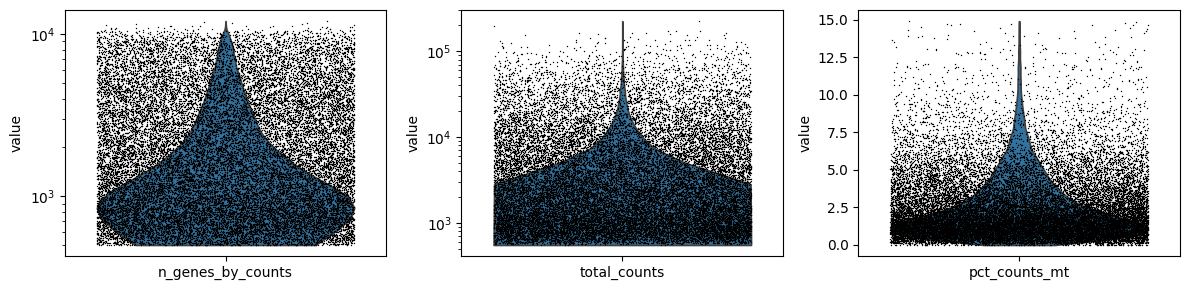

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3))
sc.pl.violin(scffpe, 'n_genes_by_counts',  jitter=0.4, ax=ax[0], show=False)
ax[0].set_yscale('log')
sc.pl.violin(scffpe, 'total_counts',  jitter=0.4, ax=ax[1], show=False)
ax[1].set_yscale('log')
sc.pl.violin(scffpe, 'pct_counts_mt',  jitter=0.4, ax=ax[2], show=False)
plt.tight_layout()

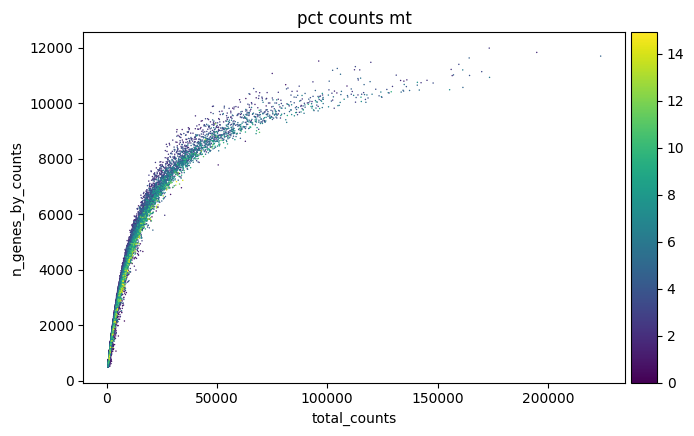

In [12]:
#Data quality summary plots
p1 = sc.pl.scatter(scffpe, 'total_counts', 'n_genes_by_counts', color='pct_counts_mt')

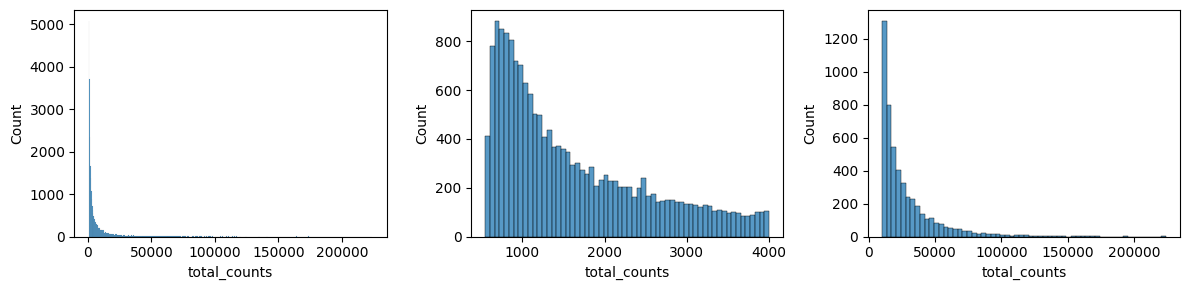

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3))

sns.histplot(scffpe.obs['total_counts'], kde=False, ax=ax[0])
sns.histplot(scffpe.obs['total_counts'][scffpe.obs['total_counts']<4000], kde=False, bins=60, ax=ax[1])
sns.histplot(scffpe.obs['total_counts'][scffpe.obs['total_counts']>10000], kde=False, bins=60, ax=ax[2])
plt.tight_layout()

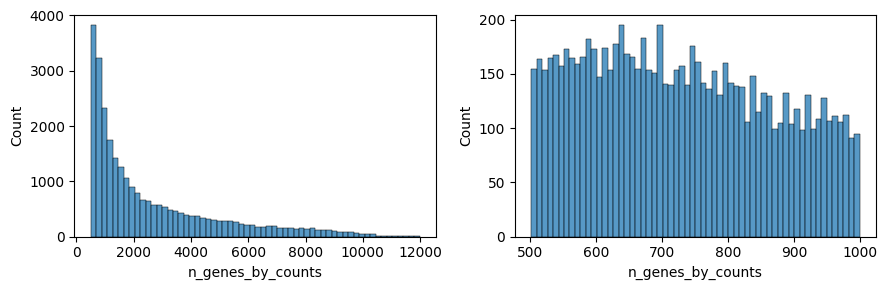

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(9, 3))
#Thresholding decision: genes
sns.histplot(scffpe.obs['n_genes_by_counts'], kde=False, bins=60, ax=ax[0])
sns.histplot(scffpe.obs['n_genes_by_counts'][scffpe.obs['n_genes_by_counts']<1000], kde=False, bins=60, ax=ax[1])
plt.tight_layout()

We filter some of the cells with very large counts.

In [15]:
sc.pp.filter_cells(scffpe, max_counts = 1e5)

And finish the preprocessing by lognormalizing the counts.

In [16]:
scffpe.layers["counts"] = scffpe.X.copy()
sc.pp.normalize_total(scffpe, inplace=True, target_sum=1e4)
sc.pp.log1p(scffpe)

In [17]:
umap(scffpe, basis='pca_scffpe')

In [18]:
scffpe

AnnData object with n_obs × n_vars = 27371 × 18082
    obs: 'Cluster', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'Cluster_colors', 'log1p', 'pca_scffpe', 'X_pca_scffpe', 'umap'
    obsm: 'X_pca_scffpe', 'X_pca_scffpe_umap'
    varm: 'PCs_pca_scffpe'
    layers: 'counts'
    obsp: 'X_pca_scffpe_distances', 'X_pca_scffpe_connectivities'

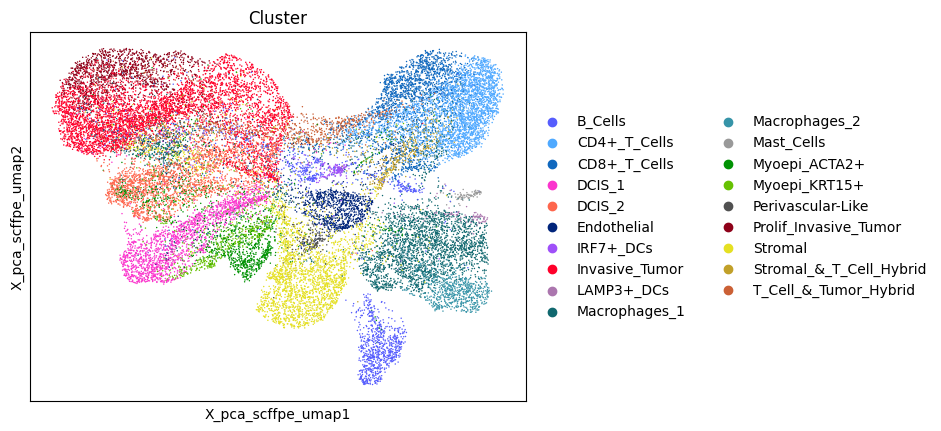

In [19]:
sc.pl.embedding(scffpe, basis='X_pca_scffpe_umap', color='Cluster')

### Concatenate the data

We add the batch variable `Tech` to both `anndata` objects and concatenate both objects.

In [20]:
# Note adjust: paths
xenium_concat = sc.read_h5ad('xenium_rep1.h5ad')
scffpe_concat = sc.read_h5ad('scFFPE_raw.h5ad')

In [21]:
xenium_concat.obs['Tech'] = 'xenium'

In [22]:
scffpe_concat.obs['Tech'] = 'scffpe'

In [26]:
xenium_concat = xenium_concat[xenium.obs.sample(5000).index]

In [27]:
scffpe_concat = scffpe_concat[scffpe.obs.sample(5000).index]

In [28]:
adata = ad.concat([xenium_concat, scffpe_concat])

In [29]:
adata.layers['counts'] = adata.X

In [30]:
adata.uns['Cluster_colors'] = [ cell_type_color[x] for x in  adata.obs['Cluster'].cat.categories ] 

### Preprocess data

Naive application of dimensionality reduction (PCA) and results in an UMAP representation in which cell strictly separate by condition.

In [31]:
sc.pp.normalize_total(adata, inplace=True, target_sum=1e4)
sc.pp.log1p(adata)

In [32]:
umap(adata, 'uncorrected')

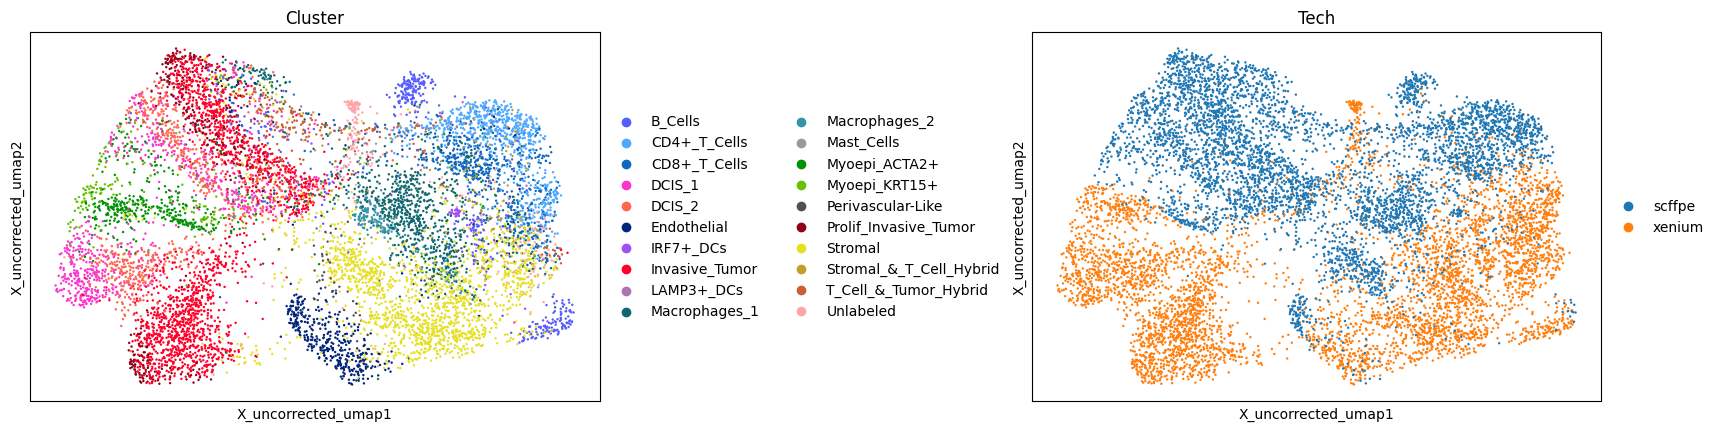

In [33]:
sc.pl.embedding(adata, basis='X_uncorrected_umap', color=['Cluster', 'Tech'], wspace=.6)

## Batch integration methods

### Combat


Combat is a batch integration method originally developed for microarray dataset. It belongs to the family of linear methods that attempt to mitigate technical effects by adjusting for individual batches for their mean and scale (standard deviation). In other words, Combat assumes that the batch effects can be factored out by standardizing means and variances across batches. Importantly, Combat achieves robustness by pooling information across genes using a empirical Bayes estimator. Generally, Combat works best on small data with moderate technical variation.

Combat implicitly assumes that means and standard deviations are constant across all samples of a batch. Could this be a problem in the context of single-cell data ? Why ?

In [34]:
adata.layers['combat'] = sc.pp.combat(adata, key='Tech', inplace=False)

In [35]:
adata.obsm['X_combat'] = sc.pp.pca(adata.layers['combat'], n_comps=20)

In [36]:
umap(adata, basis='X_combat')

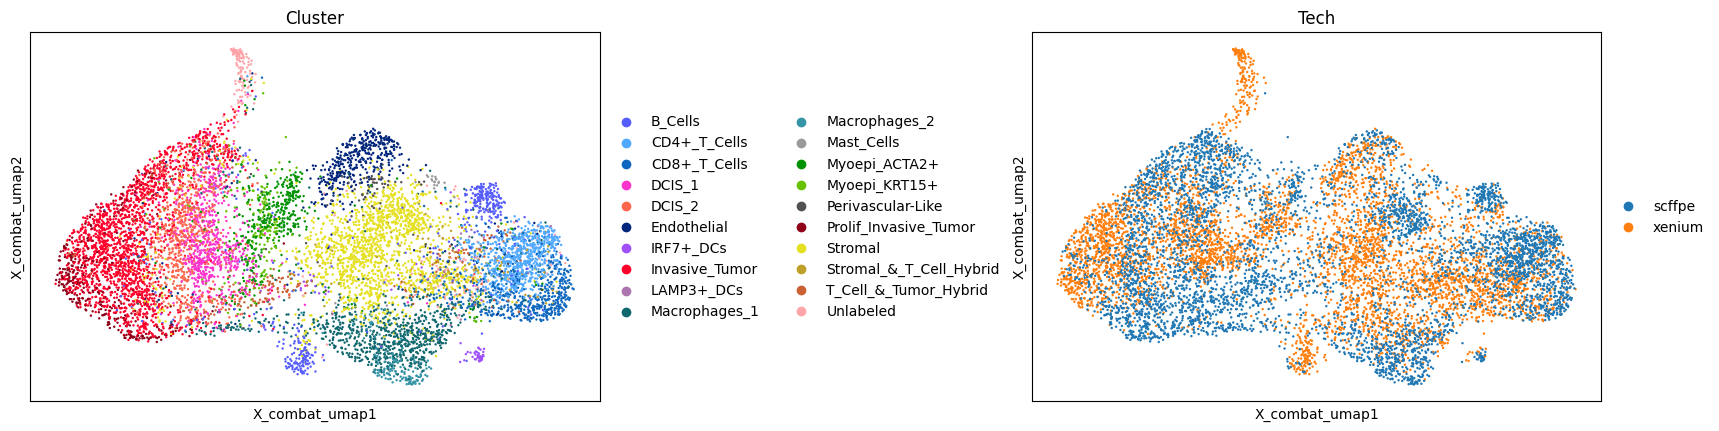

In [37]:
sc.pl.embedding(adata, basis='X_combat_umap', color=['Cluster', 'Tech'], wspace=.6)

### Harmony

Harmony uses PCA factors (cell embeddings) as a starting point to cluster each cell to potentially multiple clusters (*soft-clustering*, "maximum-diversity clustering"). After this first step, each dataset contains cluster-specific centroids which correspond to cell types. These centroids are then used to compute cluster-specific linear correction factors that are are applied to each cell. This procedure is iterated until the clusters are stable. Harmony has been reported to be appropriate for simple integration tasks with distinct batch and biological structure.

Instead of operating directly on the expression matrix, `harmony` operates on cell embeddings. Why ?

In [38]:
sce.pp.harmony_integrate(adata, basis='X_uncorrected', key='Tech')

2024-02-28 16:02:35,700 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-02-28 16:02:40,502 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-02-28 16:02:40,559 - harmonypy - INFO - Iteration 1 of 10
2024-02-28 16:02:42,684 - harmonypy - INFO - Iteration 2 of 10
2024-02-28 16:02:45,557 - harmonypy - INFO - Iteration 3 of 10
2024-02-28 16:02:48,719 - harmonypy - INFO - Iteration 4 of 10
2024-02-28 16:02:50,786 - harmonypy - INFO - Iteration 5 of 10
2024-02-28 16:02:53,009 - harmonypy - INFO - Iteration 6 of 10
2024-02-28 16:02:55,188 - harmonypy - INFO - Iteration 7 of 10
2024-02-28 16:02:57,126 - harmonypy - INFO - Iteration 8 of 10
2024-02-28 16:02:59,248 - harmonypy - INFO - Iteration 9 of 10
2024-02-28 16:03:01,606 - harmonypy - INFO - Iteration 10 of 10
2024-02-28 16:03:02,534 - harmonypy - INFO - Converged after 10 iterations


In [39]:
umap(adata, basis='X_pca_harmony')

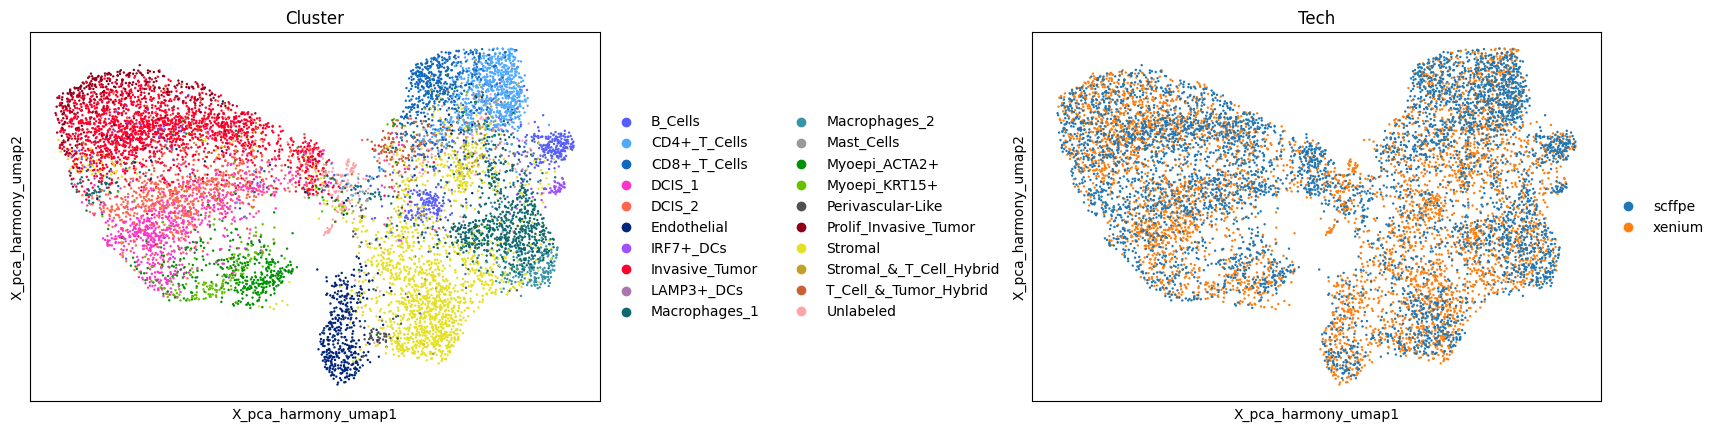

In [40]:
sc.pl.embedding(adata, basis='X_pca_harmony_umap', color=['Cluster', 'Tech'], wspace=.6)

### Scanorama


Scanorama differentiates itself from other batch-integration tools by relaxing the prior assumptions that all batches contain at least one shared cell type. Conceptually, Scanorama employs approaches from computer vision algorithms designed for panorama stitching but fundamentally aligns batches by mutal nearest-neighbors matching. Luetcken et. al. advise Scanorama for more complex integration tasks.

In [41]:
idx = adata.obs.sort_values("Tech").index
adata = adata[idx]

In [42]:
sce.pp.scanorama_integrate(adata, key='Tech', basis='X_uncorrected')

[[0.   0.75]
 [0.   0.  ]]
Processing datasets scffpe <=> xenium


In [43]:
umap(adata, basis='X_scanorama')

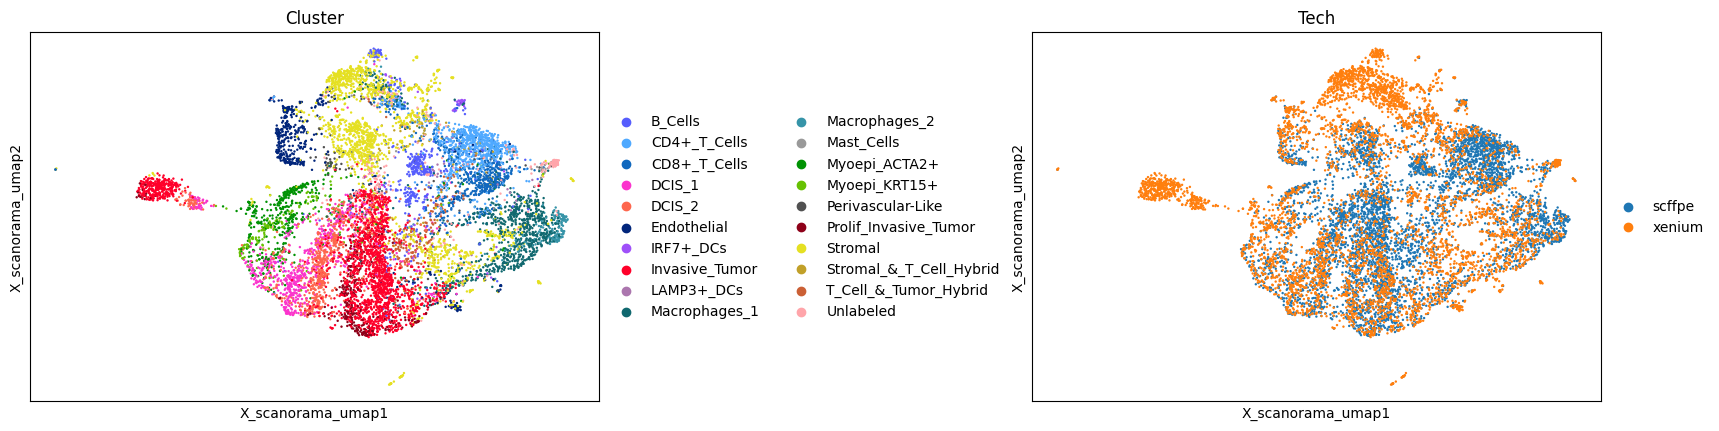

In [44]:
sc.pl.embedding(adata, basis='X_scanorama_umap', color=['Cluster', 'Tech'], wspace=.6)

### BBKNN

In contrast to most other approaches BBKNN operates directly operates on the nearest neighbourhood representation (KNN) graph representation of the data. BBKNN computes the KNN graph on each batch individually so that each cell has an independent pool of neighbours and subsequently merges those neighbourhood sets across batches.

In [45]:
sce.pp.bbknn(adata, batch_key='Tech', use_rep='X_uncorrected')

In [46]:
# BBKNN returns a corrected KNN-graph. To keep the structure of our anndata object consistent we'll copy the graph and its associated meta data ...
adata.obsp['X_bbknn_distances'] = adata.obsp['distances']
adata.obsp['X_bbknn_connectivities'] = adata.obsp['connectivities']
adata.uns['X_bbknn'] = adata.uns['neighbors']
adata.uns['X_bbknn']['distances_key'] = 'X_bbknn_distances'
adata.uns['X_bbknn']['connectivities_key'] = 'X_bbknn_connectivities'

In [47]:
# ... and delete the original keys created by the scp.pp.bkknn function.
del adata.obsp['distances']
del adata.obsp['connectivities']
del adata.uns['neighbors']

In [48]:
sc.tl.umap(adata, neighbors_key='X_bbknn')

In [49]:
adata.obsm['X_bbknn_umap'] = adata.obsm['X_umap']

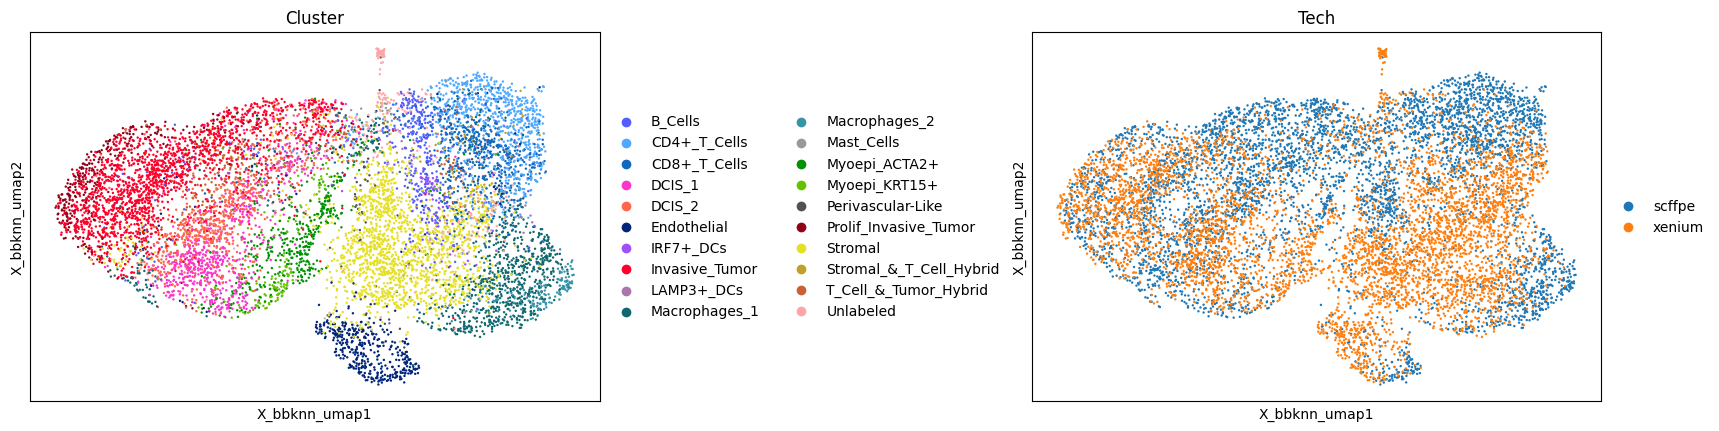

In [50]:
sc.pl.embedding(adata, basis='X_bbknn_umap', color=['Cluster', 'Tech'], wspace=.6)

### SCVI

scVI employs a more complex model architecture called variational autoencoder. Here the transcriptome of each cell is encoded through a non-linear function (encoder) into a low-dimensional vector of normal random variables. This representation is then used by another non-linear transformation (decoder) to predict the gene actual counts of each cell. 

What is the difference between a conventional PCA and an autoencoder ?

In [51]:
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="Tech")

In [52]:
model = scvi.model.SCVI(adata, n_layers=2, n_latent=20, gene_likelihood="nb")

In [53]:
model.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 400/400: 100%|██████████████████████████████| 400/400 [05:56<00:00,  1.22it/s, v_num=1, train_loss_step=226, train_loss_epoch=236]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████████████████████████| 400/400 [05:56<00:00,  1.12it/s, v_num=1, train_loss_step=226, train_loss_epoch=236]


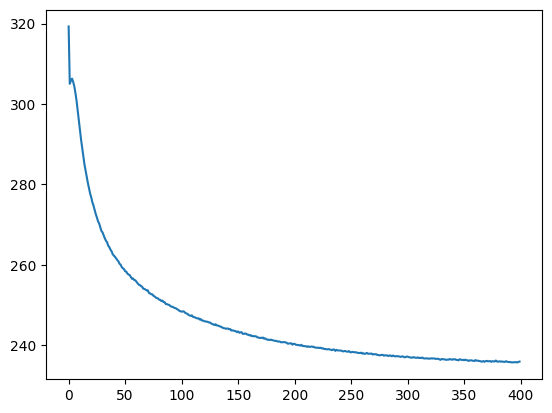

In [54]:
plt.plot(model.history["elbo_train"])
# plt.plot(model.history["elbo_"])

In [55]:
adata.obsm["X_scVI"] = model.get_latent_representation()

In [56]:
umap(adata, basis='X_scVI')

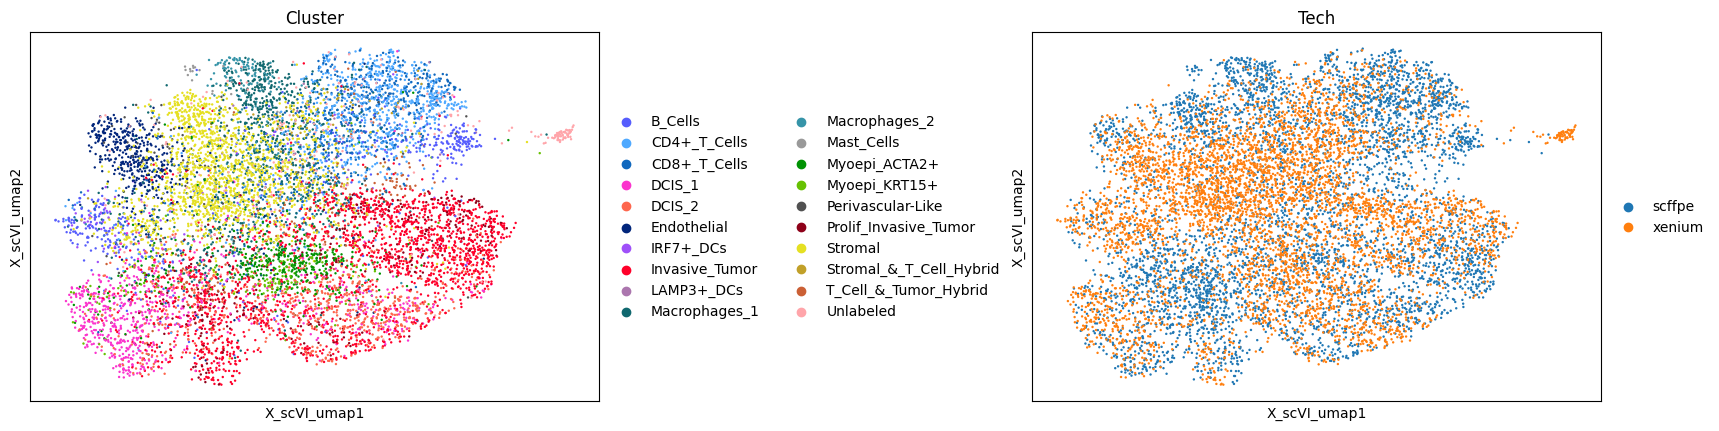

In [57]:
sc.pl.embedding(adata, basis='X_scVI_umap', color=['Cluster', 'Tech'], wspace=.6)

### Bonus: scANVI

In [58]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(
    model,
    adata=adata,
    labels_key="Cluster",
    unlabeled_category="Unknown",
)

In [59]:
scanvi_model.train(max_epochs=20, n_samples_per_label=100)

INFO     Training for 20 epochs.                                                                                   


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 20/20: 100%|██████████████████████████████████| 20/20 [01:10<00:00,  3.02s/it, v_num=1, train_loss_step=244, train_loss_epoch=227]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████████████████████████████| 20/20 [01:10<00:00,  3.55s/it, v_num=1, train_loss_step=244, train_loss_epoch=227]


In [60]:
adata.obsm["X_scANVI"] = scanvi_model.get_latent_representation(adata)

In [61]:
umap(adata, basis='X_scANVI')

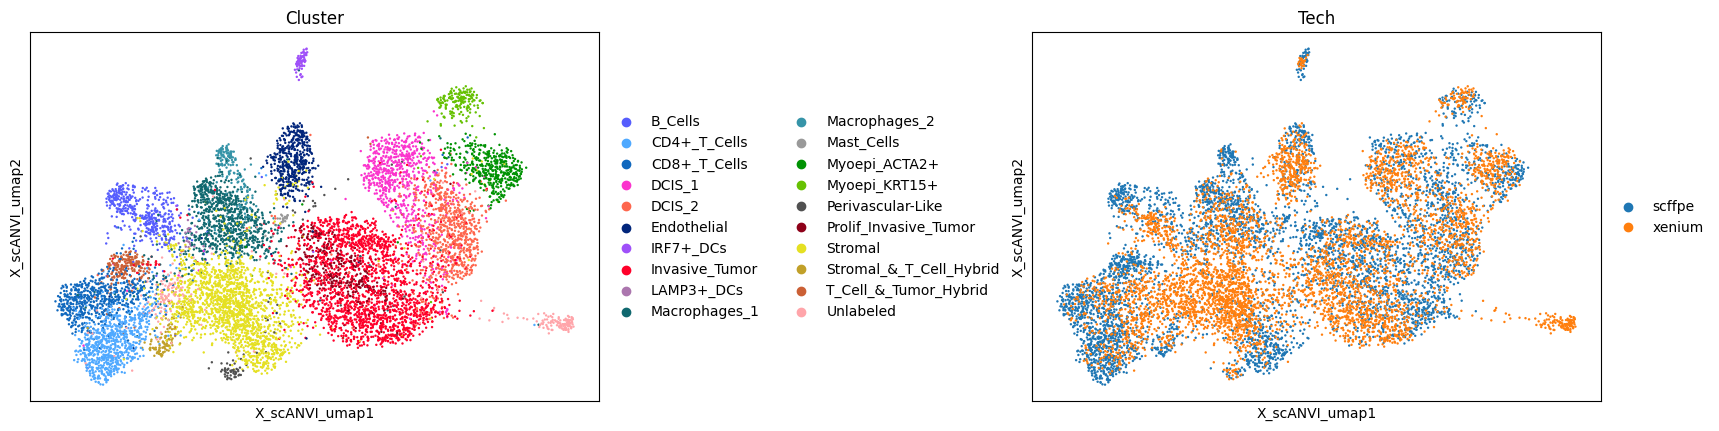

In [62]:
sc.pl.embedding(adata, basis='X_scANVI_umap', color=['Cluster', 'Tech'], wspace=.6)

## Summary

(0.0, 1.0, 0.0, 1.0)

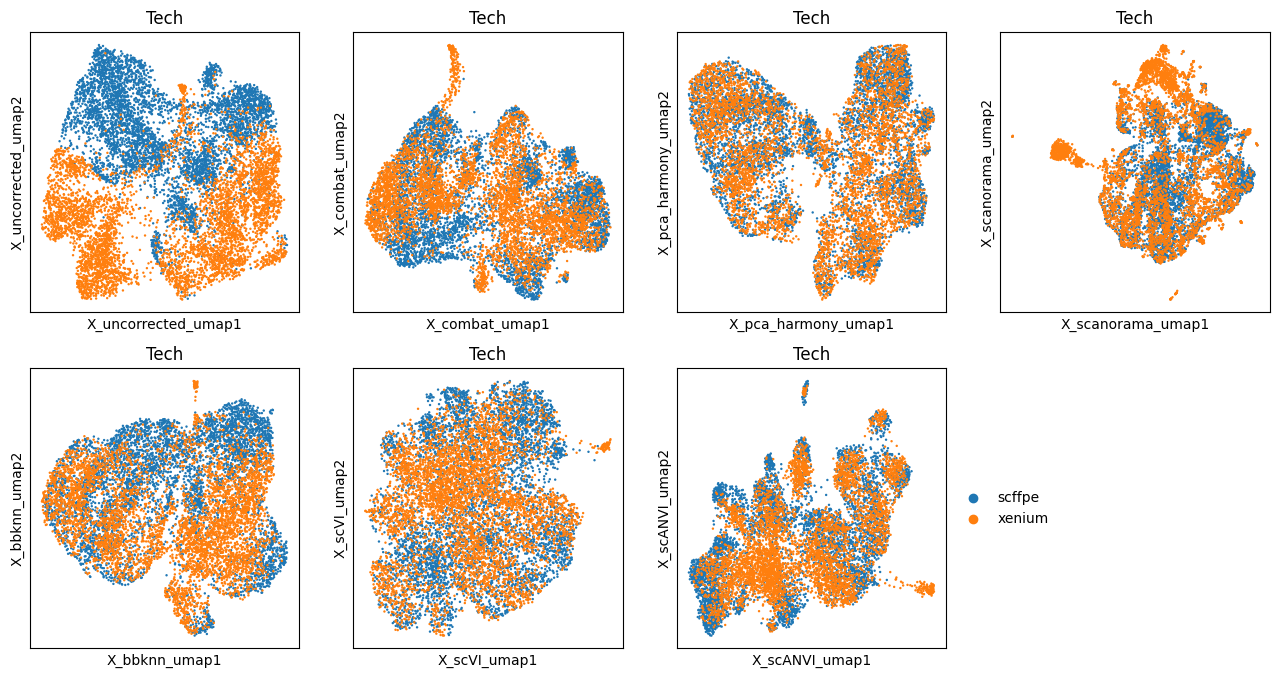

In [63]:
fig, ax = plt.subplots(2, 4, figsize=(16, 8))

sc.pl.embedding(adata, basis='X_uncorrected_umap', color='Tech', ax=ax.flatten()[0], show=False, legend_loc=False)
sc.pl.embedding(adata, basis='X_combat_umap', color='Tech', ax=ax.flatten()[1], show=False, legend_loc=False)
sc.pl.embedding(adata, basis='X_pca_harmony_umap', color='Tech', ax=ax.flatten()[2], show=False, legend_loc=False)
sc.pl.embedding(adata, basis='X_scanorama_umap', color='Tech', ax=ax.flatten()[3], show=False, legend_loc=False)
sc.pl.embedding(adata, basis='X_bbknn_umap', color='Tech', ax=ax.flatten()[4], show=False, legend_loc=False)
sc.pl.embedding(adata, basis='X_scVI_umap', color='Tech', ax=ax.flatten()[5], show=False, legend_loc=False)
sc.pl.embedding(adata, basis='X_scANVI_umap', color='Tech', ax=ax.flatten()[6], show=False)
ax.flatten()[7].axis('off')

(0.0, 1.0, 0.0, 1.0)

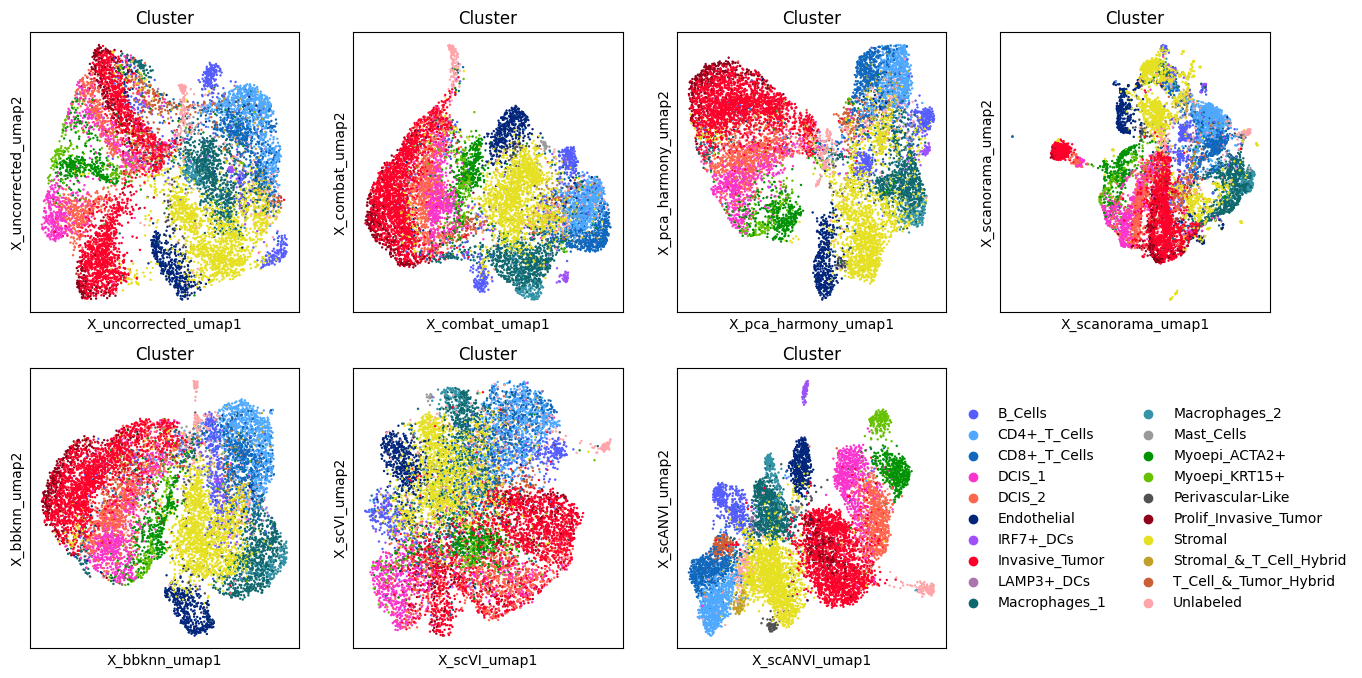

In [64]:
fig, ax = plt.subplots(2, 4, figsize=(16, 8))

sc.pl.embedding(adata, basis='X_uncorrected_umap', color='Cluster', ax=ax.flatten()[0], show=False, legend_loc=False)
sc.pl.embedding(adata, basis='X_combat_umap', color='Cluster', ax=ax.flatten()[1], show=False, legend_loc=False)
sc.pl.embedding(adata, basis='X_pca_harmony_umap', color='Cluster', ax=ax.flatten()[2], show=False, legend_loc=False)
sc.pl.embedding(adata, basis='X_scanorama_umap', color='Cluster', ax=ax.flatten()[3], show=False, legend_loc=False)
sc.pl.embedding(adata, basis='X_bbknn_umap', color='Cluster', ax=ax.flatten()[4], show=False, legend_loc=False)
sc.pl.embedding(adata, basis='X_scVI_umap', color='Cluster', ax=ax.flatten()[5], show=False, legend_loc=False)
sc.pl.embedding(adata, basis='X_scANVI_umap', color='Cluster', ax=ax.flatten()[6], show=False)
ax.flatten()[7].axis('off')

In [72]:
bm = Benchmarker(
    adata,
    batch_key="Tech",
    label_key="Cluster",
    embedding_obsm_keys=["X_uncorrected", "X_combat", "X_pca_harmony", "X_scanorama", "X_bbknn_umap", "X_scVI", "X_scANVI"],
    n_jobs=-1,
)

In [73]:
bm.benchmark()

Metrics:  60%|██████    | 6/10 [00:49<00:24,  6.15s/it, Batch correction: kbet_per_label]

INFO     Unlabeled consists of a single batch or is too small. Skip.                                               



Metrics:   0%|          | 0/10 [00:00<?, ?it/s]
                                                                                         
Metrics:  60%|██████    | 6/10 [00:33<00:12,  3.06s/it, Batch correction: kbet_per_label]

INFO     Unlabeled consists of a single batch or is too small. Skip.                                               



Metrics:   0%|          | 0/10 [00:00<?, ?it/s]
                                                                                         
Metrics:  60%|██████    | 6/10 [00:29<00:11,  2.77s/it, Batch correction: kbet_per_label]

INFO     Unlabeled consists of a single batch or is too small. Skip.                                               



Metrics:   0%|          | 0/10 [00:00<?, ?it/s]
                                                                                         
Metrics:  60%|██████    | 6/10 [00:30<00:11,  2.81s/it, Batch correction: kbet_per_label]

INFO     Unlabeled consists of a single batch or is too small. Skip.                                               



Metrics:   0%|          | 0/10 [00:00<?, ?it/s]
                                                                                         
Metrics:  60%|██████    | 6/10 [00:18<00:07,  1.90s/it, Batch correction: kbet_per_label]

INFO     Unlabeled consists of a single batch or is too small. Skip.                                               



Metrics:   0%|          | 0/10 [00:00<?, ?it/s]
                                                                                         
Metrics:  60%|██████    | 6/10 [00:23<00:08,  2.21s/it, Batch correction: kbet_per_label]

INFO     Unlabeled consists of a single batch or is too small. Skip.                                               



Metrics:   0%|          | 0/10 [00:00<?, ?it/s]
                                                                                         
Metrics:  60%|██████    | 6/10 [00:24<00:09,  2.30s/it, Batch correction: kbet_per_label]

INFO     Unlabeled consists of a single batch or is too small. Skip.                                               



Embeddings: 100%|██████████| 7/7 [14:33<00:00, 124.78s/it]tch correction: pcr_comparison]

                                                                                         

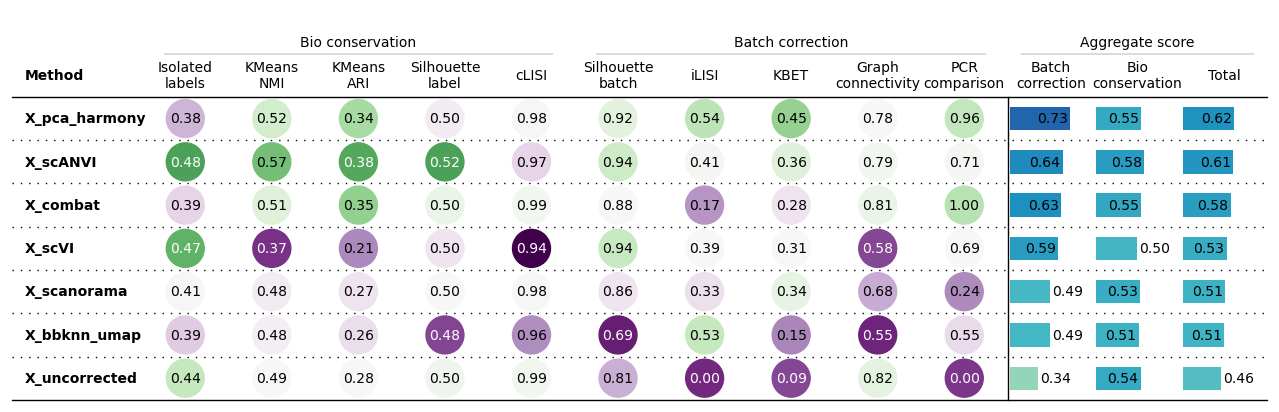

In [74]:
bm.plot_results_table(min_max_scale=False)
